# Árbol de clasificación

## 1. Importación de paquetes y librerías

In [21]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals.six import StringIO
from sklearn.metrics import r2_score, mean_squared_error,median_absolute_error
from sklearn.model_selection import cross_val_score
from statsmodels.graphics.api import abline_plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit, GridSearchCV
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot

## 2. Importar datos y asignar variables

In [22]:
loc=r"../interacciones_mensuales.csv"
data=pd.read_csv(loc,encoding="latin1",index_col=False,decimal=",",engine="python")
data = data.drop(data.columns[-20:], axis=1)

data=data[((data.Total-data.Total.mean()) / data.Total.std()).abs() <3]

### Identificación de hiper-parámetros

In [23]:
X = data.drop(["Total","Year","Cod",'P_days'],axis=1) # Asignar variables independientes
nombres = data.drop(["Total","Year","Cod",'P_days'],axis=1).columns # Nombre de las variables dependientes
y = data['Total'] # Asignar variable dependiente

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [24]:
model = GridSearchCV(DecisionTreeRegressor(max_depth=5,min_samples_split=2,
                                          criterion="mae"), cv=5,
                   param_grid={"max_depth": [4, 5, 6, 7, 8, 9, 10],
                               "min_samples_split":np.linspace(0.1,1.0,10,endpoint=True),
                               "max_features":list(range(1,len(nombres)))})
model.fit(X_train,y_train);

model.best_params_

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 7, 'max_features': 8, 'min_samples_split': 0.1}

## 3. Ajuste y validación de los modelos

### Hold out

In [45]:
R_2=[]
RMSE=[]
MAE=[]
pred=[0]
obs=[0]

for i in range(100):
    X = data.drop(["Total","Year","Cod",'P_days'],axis=1) # Asignar variables independientes
    nombres = data.drop(["Total","Year","Cod",'P_days'],axis=1).columns # Nombre de las variables dependientes
    y = data['Total'] # Asignar variable dependiente

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
    
    cacaotreeModel=DecisionTreeRegressor(max_depth=model.best_params_['max_depth'],
                                         min_samples_split=model.best_params_['min_samples_split'],
                                         max_features=model.best_params_['max_features'],criterion="mae")
    cacaotreeModel.fit(X_train,y_train)
    errorVector=y_test-cacaotreeModel.predict(X_test)
    
    r_2=r2_score(y_test,cacaotreeModel.predict(X_test))
    R_2.append(r_2)
    RMSE.append(np.linalg.norm((y_test-cacaotreeModel.predict(X_test)),2)/np.sqrt(len(y_test)))
    MAE.append(median_absolute_error(y_test,cacaotreeModel.predict(X_test)))
    
    if r_2 >= max(R_2):
        pred[0]=cacaotreeModel.predict(X_test)
        obs[0]=y_test
        
        X_Test = X_test
        y_Test = y_test
        modelo = cacaotreeModel
        
        with open("arbol_1.dot","w") as f:
            f= tree.export_graphviz(cacaotreeModel, out_file=f,filled=True, rounded=True,special_characters=True)
        b=cacaotreeModel.feature_importances_
        a=[]
        for i in range(len(nombres)):
            a.append(b[i])
        importa=pd.DataFrame(list(zip(nombres,a)),columns=["Variable","Importancia de Gini"])
        
print("R^2: %.4f" % np.mean(R_2))
print("RMSE: %.4f" % np.mean(RMSE))
print("MAE: %.4f" % np.mean(MAE))

R^2: 0.3135
RMSE: 29.2999
MAE: 11.7753


In [27]:
max(R_2), min(R_2), np.std(R_2), np.mean(R_2),np.std(RMSE)/np.mean(RMSE) 

(0.5887387330357858,
 -0.11050314737677791,
 0.13202078768212874,
 0.3373734094512436,
 0.1049443155878118)

<Figure size 432x288 with 0 Axes>

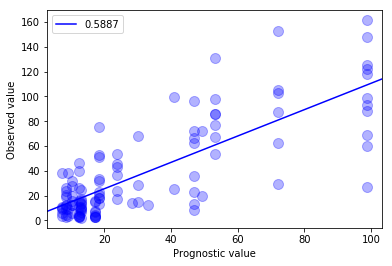

In [28]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 

plt.figure("Diagrama de dispersión")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Prognostic value")
plt.ylabel("Observed value")
plt.legend()
plt.show()

In [29]:
# Guardar los errores y el R^2
pd.DataFrame([R_2,MAE],index=["R^2","MAE"]).T.to_csv("Ajustes arbol.csv",decimal=",")

# Almacenar mejores resultados

res=pd.DataFrame([np.array(pred).flatten(),np.array(obs).flatten()]).T
res.columns=["Pronosticado","Observado"]
res.to_csv("res_arbol.csv",decimal=",",index=False)

In [31]:
print("Importancia de las variables:")
print(importa.sort_values(by="Importancia de Gini",ascending=False))
importa.sort_values(by="Importancia de Gini",ascending=False).to_csv("Importancia_arbol.csv",decimal=",")

Importancia de las variables:
             Variable  Importancia de Gini
12     Rad_accu_prev2             0.593411
11     Rad_accu_prev1             0.198949
1                   P             0.081928
22        Clon_TSH565             0.045514
9         P_accu_prev             0.018394
2                   K             0.016772
8             Hum_avg             0.011310
6              EC_avg             0.009152
19         Clon_SCC61             0.009094
16         Clon_ICS95             0.007013
5               T_avg             0.005506
17         Clon_SCC19             0.002957
21         Clon_SCC83             0.000000
0               Month             0.000000
23         Level_50.0             0.000000
24        Level_100.0             0.000000
25        Level_150.0             0.000000
26     Exposicion_SOL             0.000000
20         Clon_SCC64             0.000000
14          Clon_EET8             0.000000
18         Clon_SCC52             0.000000
15          Clon_ICS1   

## Curva de aprendizaje

<module 'matplotlib.pyplot' from 'C:\\Users\\Usuario\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

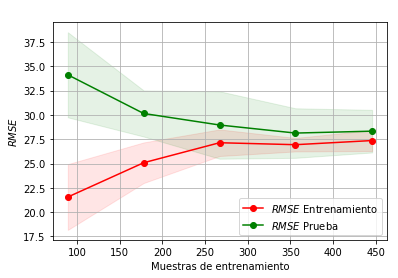

In [32]:
import Curva

X=data.drop(["Total","Year","Cod",'P_days'],axis=1).values # Asignar variables independientes
y=data['Total'].values # Asignar variable dependiente

# Normalización de los atributos
scaler= preprocessing.StandardScaler().fit(X)
X_scaled=scaler.transform(X)

title = " "

cv = ShuffleSplit(n_splits=10, test_size=0.2)
estimator = DecisionTreeRegressor(max_depth=model.best_params_['max_depth'],
                                  min_samples_split=model.best_params_['min_samples_split'],
                                  max_features=model.best_params_['max_features'],criterion="mae")

Curva.plot_learning_curve(estimator, title, X_scaled, y, cv=cv, n_jobs=4)
#plt.savefig("LC árbol.jpg",dpi=600);

## Estrategia de oscilación

In [33]:
predictores = nombres
X_ = pd.DataFrame(X_Test,columns=nombres)
y = y_Test

In [34]:
var = ['T_avg','T_avg _prev',"P_accu", "P_accu_prev","Rad_accu","Rad_accu_prev1","Rad_accu_prev2","Hum_avg","EC_avg"]

In [35]:
X.shape
y.shape

(112,)

In [36]:
R_2 = []
RMSE = []
MAE = []
pre = []
rango = []

for i in var:
    
    X = X_.copy()
    promedio = []
    
    for j in np.linspace(X[i].min(), X[i].max(),100):
        
        X[i] = j
        
        prediction = modelo.predict(X)

        r_2=r2_score(y,prediction)
        R_2.append(r_2)
        promedio.append(np.mean(prediction))
        pre.append(np.mean(prediction))
        RMSE.append(np.linalg.norm((y-prediction),2)/np.sqrt(len(y)))
        MAE.append(median_absolute_error(y,prediction))
        
    rango.append(max(promedio)-min(promedio))

In [37]:
dic = {}

for i in var:
    if i not in dic:
        dic[i] = np.linspace(X_[i].min(), X_[i].max(),100)

RMSE_1 = RMSE[:100]
RMSE_2 = RMSE[100:200]
RMSE_3 = RMSE[200:300]
RMSE_4 = RMSE[300:400]
RMSE_5 = RMSE[400:500]
RMSE_6 = RMSE[500:600]
RMSE_7 = RMSE[600:700]
RMSE_8 = RMSE[-100:]

PRE_1 = pre[:100]
PRE_2 = pre[100:200]
PRE_3 = pre[200:300]
PRE_4 = pre[300:400]
PRE_5 = pre[400:500]
PRE_6 = pre[500:600]
PRE_7 = pre[600:700]
PRE_8 = pre[-100:]

In [38]:
pde = pd.DataFrame(dic)
pde["RMSE_1"],pde["RMSE_2"],pde["RMSE_3"],pde["RMSE_4"],pde["RMSE_5"],pde["RMSE_6"],pde["RMSE_7"],pde["RMSE_8"] = RMSE_1,RMSE_2,RMSE_3,RMSE_4,RMSE_5,RMSE_6,RMSE_7,RMSE_8
pde["PRE_1"],pde["PRE_2"],pde["PRE_3"],pde["PRE_4"],pde["PRE_5"],pde["PRE_6"],pde["PRE_7"],pde["PRE_8"] = PRE_1,PRE_2,PRE_3,PRE_4,PRE_5,PRE_6,PRE_7,PRE_8
pde.to_csv("Evaluación_arbol.csv",decimal=",",index=False)

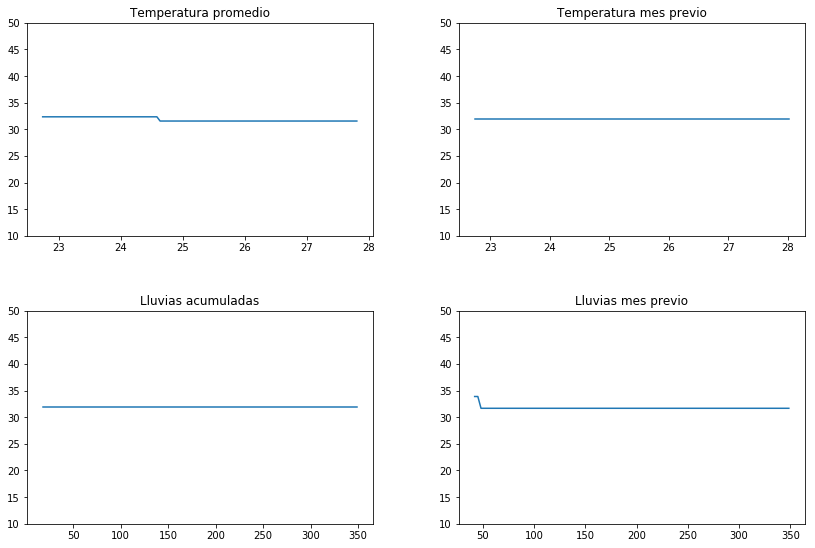

In [39]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.ylim(10,50)
plt.title("Temperatura promedio")
plt.plot(pde.T_avg,pde.PRE_1)

plt.subplot(2,2,2)
plt.ylim(10,50)
plt.title("Temperatura mes previo")
plt.plot(pde['T_avg _prev'],pde.PRE_2)

plt.subplot(2,2,3)
plt.ylim(10,50)
plt.title("Lluvias acumuladas")
plt.plot(pde.P_accu,pde.PRE_3)

plt.subplot(2,2,4)
plt.ylim(10,50)
plt.title("Lluvias mes previo")
plt.plot(pde.P_accu_prev,pde.PRE_4)

plt.subplots_adjust(top=0.92,bottom=0.05,left=0.05,right=0.95,
                   hspace=0.35,wspace=0.25)

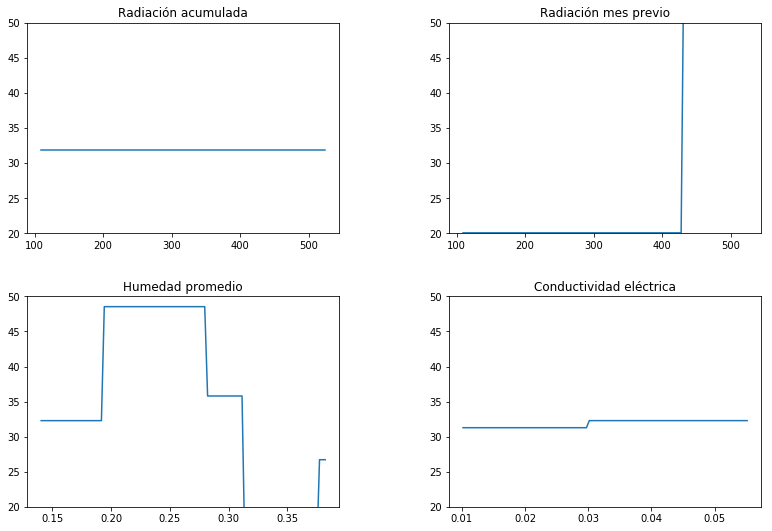

In [40]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.ylim(20,50)
plt.title("Radiación acumulada")
plt.plot(pde.Rad_accu,pde.PRE_5)

plt.subplot(2,2,2)
plt.ylim(20,50)
plt.title("Radiación mes previo")
plt.plot(pde.Rad_accu_prev1,pde.PRE_6)

plt.subplot(2,2,3)
plt.ylim(20,50)
plt.title("Humedad promedio")
plt.plot(pde.Hum_avg,pde.PRE_7)

plt.subplot(2,2,4)
plt.ylim(20,50)
plt.title("Conductividad eléctrica")
plt.plot(pde.EC_avg,pde.PRE_8)

plt.subplots_adjust(top=0.92,bottom=0.08,left=0.1,right=0.95,
                   hspace=0.3,wspace=0.35)